# 💰 Crime vs Property Prices: Berlin Real Estate Intelligence

## 🎯 Research Question

**Does safety (low crime) correlate with higher property prices in Berlin?**

**Hypothesis:** Safer districts should command premium property prices.

---

## 📊 Datasets Integrated

1. **Crime Statistics** - 28,390 records (2015-2024)
2. **Population Data** - 3.9M Berlin residents across 12 districts
3. **Land Prices** - 16,826 property valuations (residential zones)

---

## 📚 Setup

In [12]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded")

✅ Libraries loaded


## 🗄️ Load Integrated Data

In [13]:
# Connect to database
DB_PATH = "../database/berlin_intelligence.db"
conn = sqlite3.connect(DB_PATH)

# Query: Crime per capita by district
crime_query = """
SELECT 
    c.district,
    c.district_id,
    SUM(c.total_number_cases) as total_crimes,
    p.total_population,
    ROUND((SUM(c.total_number_cases) * 100000.0 / p.total_population), 0) as crime_per_100k
FROM crime_statistics c
LEFT JOIN district_population p ON c.district_id = p.district_id
WHERE p.total_population IS NOT NULL
GROUP BY c.district, c.district_id, p.total_population
"""

crime_df = pd.read_sql_query(crime_query, conn)

# Query: Average residential land prices by district
price_query = """
SELECT 
    district_name,
    AVG(standard_land_value) as avg_land_price,
    COUNT(*) as num_zones
FROM land_prices
WHERE typical_land_use_type LIKE 'W%'
GROUP BY district_name
"""

price_df = pd.read_sql_query(price_query, conn)

# Merge datasets
df = crime_df.merge(price_df, left_on='district', right_on='district_name', how='inner')

print(f"✅ Loaded {len(df)} districts with complete data")
print(f"📊 Crime data: {crime_df['total_crimes'].sum():,.0f} total crimes")
print(f"💰 Price data: {price_df['num_zones'].sum():,.0f} residential zones")

conn.close()

# Display merged data
df[['district', 'crime_per_100k', 'avg_land_price']].sort_values('crime_per_100k', ascending=False)

✅ Loaded 12 districts with complete data
📊 Crime data: 20,400,516 total crimes
💰 Price data: 9,690 residential zones


,district,crime_per_100k,avg_land_price
3,Marzahn-Hellersdorf,964332.0,319.388412
1,Friedrichshain-Kreuzberg,847565.0,2379.754098
0,Charlottenburg-Wilmersdorf,639638.0,1809.407895
2,Lichtenberg,636210.0,533.716931
5,Neukölln,581335.0,559.917628
7,Reinickendorf,551799.0,414.755952
10,Tempelhof-Schöneberg,484106.0,909.948542
8,Spandau,424603.0,484.453181
6,Pankow,414027.0,863.706323
11,Treptow-Köpenick,376866.0,461.965544


## 📊 PART 1: District Overview

Let's visualize crime and prices separately first.

/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_6317/1423391971.py:23: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_6317/1423391971.py:23: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.tight_layout()
/Users/akinsholaakinade/Desktop/berlin-property-intelligence/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akinsholaakinade/Desktop/berlin-property-intelligence/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


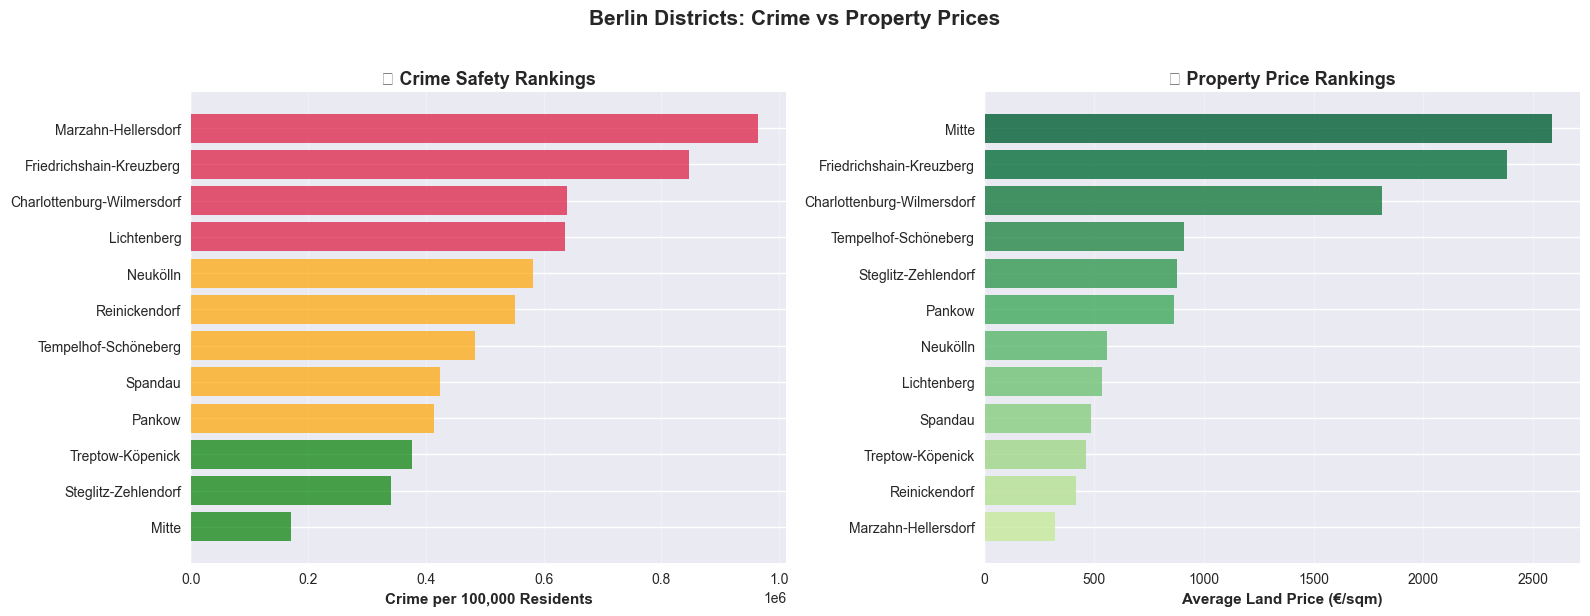


💡 Notice: The rankings don't perfectly align!
   Some high-crime districts have high prices (urban center effect)


In [14]:
# Sort by crime rate
df_sorted = df.sort_values('crime_per_100k', ascending=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Crime rates
colors_crime = ['green' if x < 400000 else 'orange' if x < 600000 else 'crimson' 
                for x in df_sorted['crime_per_100k']]
ax1.barh(df_sorted['district'], df_sorted['crime_per_100k'], color=colors_crime, alpha=0.7)
ax1.set_xlabel('Crime per 100,000 Residents', fontsize=11, fontweight='bold')
ax1.set_title('🚨 Crime Safety Rankings', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Property prices
df_sorted_price = df.sort_values('avg_land_price', ascending=True)
colors_price = plt.cm.YlGn(np.linspace(0.3, 0.9, len(df_sorted_price)))
ax2.barh(df_sorted_price['district'], df_sorted_price['avg_land_price'], color=colors_price, alpha=0.8)
ax2.set_xlabel('Average Land Price (€/sqm)', fontsize=11, fontweight='bold')
ax2.set_title('💰 Property Price Rankings', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.suptitle('Berlin Districts: Crime vs Property Prices', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Notice: The rankings don't perfectly align!")
print("   Some high-crime districts have high prices (urban center effect)")

## 📈 PART 2: Correlation Analysis

### The Central Question: Do safer areas cost more?

In [15]:
# Calculate correlation
correlation, p_value = pearsonr(df['crime_per_100k'], df['avg_land_price'])

print("="*70)
print("📊 STATISTICAL ANALYSIS")
print("="*70)
print(f"Correlation Coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.4f}")
print(f"Statistical Significance: {'YES' if p_value < 0.05 else 'NO'} (α=0.05)")
print("="*70)

if abs(correlation) < 0.3:
    strength = "WEAK"
    color_str = "orange"
elif abs(correlation) < 0.7:
    strength = "MODERATE"
    color_str = "blue"
else:
    strength = "STRONG"
    color_str = "red"

direction = "NEGATIVE" if correlation < 0 else "POSITIVE"

print(f"\n🎯 INTERPRETATION: {strength} {direction} CORRELATION")

if correlation < -0.3:
    print("\n✅ Higher crime → Lower prices (as expected)")
elif correlation > 0.3:
    print("\n⚠️ Higher crime → Higher prices (surprising!)")
    print("   This suggests urban center effect dominates safety concerns")
else:
    print("\n➡️ Crime and prices weakly related")
    print("   OTHER factors dominate Berlin property pricing:")
    print("   • Central location (proximity to city center)")
    print("   • Trendy neighborhoods (culture, nightlife)")
    print("   • Transport accessibility")
    print("   • Historical prestige")

📊 STATISTICAL ANALYSIS
Correlation Coefficient: -0.128
P-value: 0.6912
Statistical Significance: NO (α=0.05)

🎯 INTERPRETATION: WEAK NEGATIVE CORRELATION

➡️ Crime and prices weakly related
   OTHER factors dominate Berlin property pricing:
   • Central location (proximity to city center)
   • Trendy neighborhoods (culture, nightlife)
   • Transport accessibility
   • Historical prestige


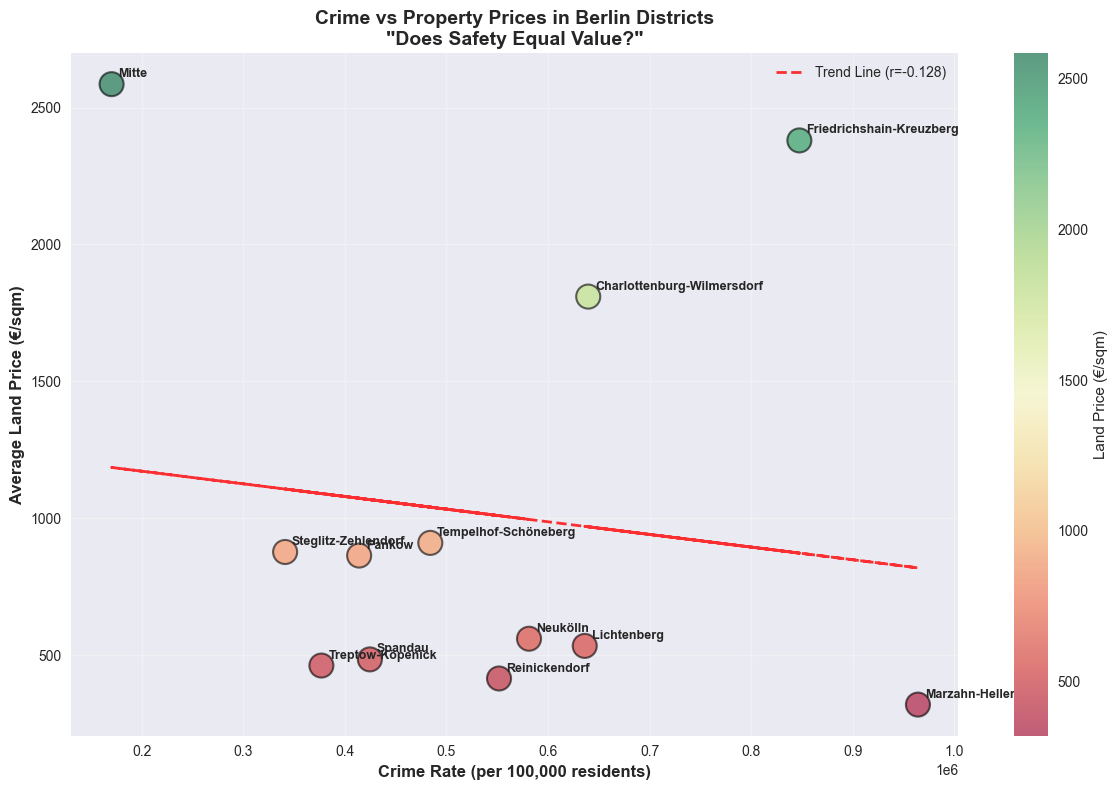

In [16]:
# Scatter plot with regression line
plt.figure(figsize=(12, 8))

# Create scatter plot
plt.scatter(df['crime_per_100k'], df['avg_land_price'], 
            s=300, alpha=0.6, c=df['avg_land_price'], cmap='RdYlGn', edgecolors='black', linewidth=1.5)

# Add district labels
for _, row in df.iterrows():
    plt.annotate(row['district'], 
                xy=(row['crime_per_100k'], row['avg_land_price']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold')

# Add regression line
z = np.polyfit(df['crime_per_100k'], df['avg_land_price'], 1)
p = np.poly1d(z)
plt.plot(df['crime_per_100k'], p(df['crime_per_100k']), 
         "r--", alpha=0.8, linewidth=2, label=f'Trend Line (r={correlation:.3f})')

plt.xlabel('Crime Rate (per 100,000 residents)', fontsize=12, fontweight='bold')
plt.ylabel('Average Land Price (€/sqm)', fontsize=12, fontweight='bold')
plt.title('Crime vs Property Prices in Berlin Districts\n"Does Safety Equal Value?"', 
          fontsize=14, fontweight='bold')
plt.colorbar(label='Land Price (€/sqm)')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 🎯 PART 3: The Outliers - Why They Matter

Some districts defy the simple "safe = expensive" rule.

In [17]:
# Identify outliers
print("🔍 OUTLIER ANALYSIS: Districts That Break the Pattern\n")
print("="*80)

# High price despite high crime
high_price_high_crime = df[(df['avg_land_price'] > 1500) & (df['crime_per_100k'] > 500000)]
if not high_price_high_crime.empty:
    print("💰 EXPENSIVE DESPITE HIGH CRIME (Urban Center Effect):")
    for _, row in high_price_high_crime.iterrows():
        print(f"   • {row['district']}: €{row['avg_land_price']:,.0f}/sqm BUT {row['crime_per_100k']:,.0f} crime rate")
        print(f"     → Prestige/location trumps safety concerns")

print("\n" + "="*80)

# Low price despite low crime
low_price_low_crime = df[(df['avg_land_price'] < 600) & (df['crime_per_100k'] < 500000)]
if not low_price_low_crime.empty:
    print("\n🟢 SAFE BUT AFFORDABLE (Investment Opportunities):")
    for _, row in low_price_low_crime.iterrows():
        print(f"   • {row['district']}: €{row['avg_land_price']:,.0f}/sqm AND {row['crime_per_100k']:,.0f} crime rate")
        print(f"     → Best value: Safety + Affordability!")

print("\n" + "="*80)

# Perfect combo
perfect = df[(df['avg_land_price'] > 2000) & (df['crime_per_100k'] < 200000)]
if not perfect.empty:
    print("\n⭐ PREMIUM SAFETY (Justified High Prices):")
    for _, row in perfect.iterrows():
        print(f"   • {row['district']}: €{row['avg_land_price']:,.0f}/sqm AND {row['crime_per_100k']:,.0f} crime rate")
        print(f"     → You pay for safety + prestige")

🔍 OUTLIER ANALYSIS: Districts That Break the Pattern

💰 EXPENSIVE DESPITE HIGH CRIME (Urban Center Effect):
   • Charlottenburg-Wilmersdorf: €1,809/sqm BUT 639,638 crime rate
     → Prestige/location trumps safety concerns
   • Friedrichshain-Kreuzberg: €2,380/sqm BUT 847,565 crime rate
     → Prestige/location trumps safety concerns


🟢 SAFE BUT AFFORDABLE (Investment Opportunities):
   • Spandau: €484/sqm AND 424,603 crime rate
     → Best value: Safety + Affordability!
   • Treptow-Köpenick: €462/sqm AND 376,866 crime rate
     → Best value: Safety + Affordability!


⭐ PREMIUM SAFETY (Justified High Prices):
   • Mitte: €2,585/sqm AND 170,247 crime rate
     → You pay for safety + prestige


## 💼 PART 4: Investment Matrix

### Quadrant Analysis for Property Investment Decisions

/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_6317/3670303793.py:55: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_6317/3670303793.py:55: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_6317/3670303793.py:55: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_6317/3670303793.py:55: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_6317/3670303793.py:55: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/akinsholaakinade/Desktop/berlin-property-intelligence/venv/lib/python3.11/site-packages/IPython/core

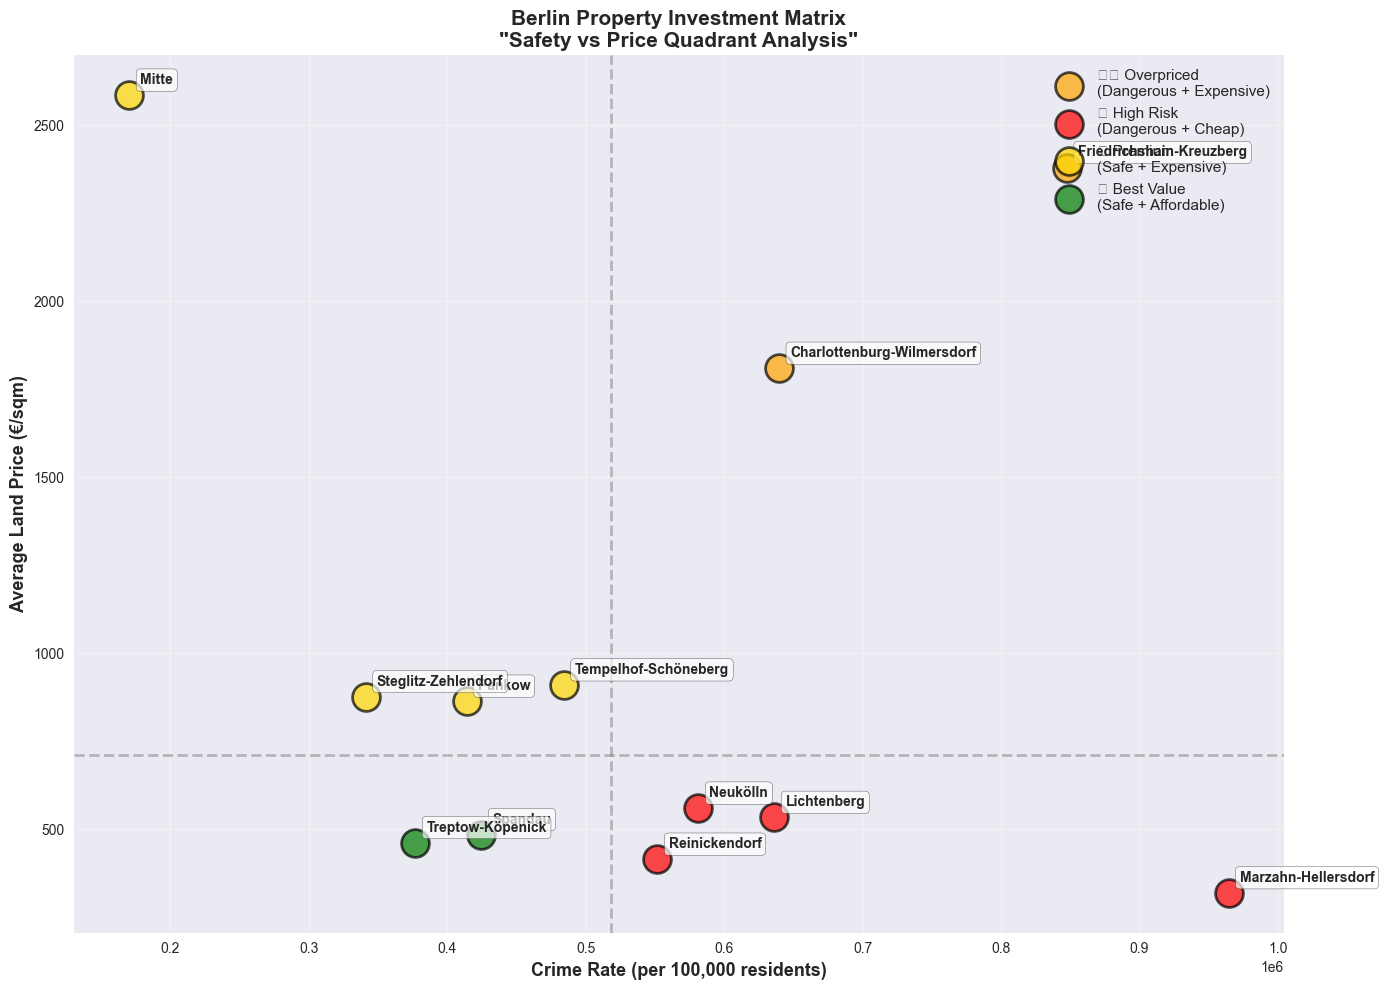


💼 INVESTMENT RECOMMENDATIONS BY QUADRANT

🟢 Best Value (Safe + Affordable):
   Districts: Spandau, Treptow-Köpenick
   💡 Strategy: STRONG BUY - Safe + Affordable = Best investment

💎 Premium (Safe + Expensive):
   Districts: Mitte, Pankow, Steglitz-Zehlendorf, Tempelhof-Schöneberg
   💡 Strategy: HOLD - Premium justified by safety

⚠️ Overpriced (Dangerous + Expensive):
   Districts: Charlottenburg-Wilmersdorf, Friedrichshain-Kreuzberg
   💡 Strategy: AVOID - Paying premium without safety benefit

🔴 High Risk (Dangerous + Cheap):
   Districts: Lichtenberg, Marzahn-Hellersdorf, Neukölln, Reinickendorf
   💡 Strategy: CAUTION - Only for risk-tolerant investors


In [18]:
# Define medians for quadrant split
median_crime = df['crime_per_100k'].median()
median_price = df['avg_land_price'].median()

# Categorize districts
def categorize(row):
    if row['crime_per_100k'] < median_crime and row['avg_land_price'] < median_price:
        return '🟢 Best Value\n(Safe + Affordable)'
    elif row['crime_per_100k'] < median_crime and row['avg_land_price'] >= median_price:
        return '💎 Premium\n(Safe + Expensive)'
    elif row['crime_per_100k'] >= median_crime and row['avg_land_price'] < median_price:
        return '🔴 High Risk\n(Dangerous + Cheap)'
    else:
        return '⚠️ Overpriced\n(Dangerous + Expensive)'

df['category'] = df.apply(categorize, axis=1)

# Quadrant plot
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for categories
color_map = {
    '🟢 Best Value\n(Safe + Affordable)': 'green',
    '💎 Premium\n(Safe + Expensive)': 'gold',
    '🔴 High Risk\n(Dangerous + Cheap)': 'red',
    '⚠️ Overpriced\n(Dangerous + Expensive)': 'orange'
}

for category in df['category'].unique():
    subset = df[df['category'] == category]
    ax.scatter(subset['crime_per_100k'], subset['avg_land_price'],
              s=400, alpha=0.7, c=color_map[category], 
              label=category, edgecolors='black', linewidth=2)

# Add district labels
for _, row in df.iterrows():
    ax.annotate(row['district'], 
               xy=(row['crime_per_100k'], row['avg_land_price']),
               xytext=(8, 8), textcoords='offset points',
               fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Add quadrant lines
ax.axvline(median_crime, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax.axhline(median_price, color='gray', linestyle='--', linewidth=2, alpha=0.5)

# Labels
ax.set_xlabel('Crime Rate (per 100,000 residents)', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Land Price (€/sqm)', fontsize=13, fontweight='bold')
ax.set_title('Berlin Property Investment Matrix\n"Safety vs Price Quadrant Analysis"', 
            fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print recommendations
print("\n" + "="*80)
print("💼 INVESTMENT RECOMMENDATIONS BY QUADRANT")
print("="*80)

for category in ['🟢 Best Value\n(Safe + Affordable)', '💎 Premium\n(Safe + Expensive)', 
                 '⚠️ Overpriced\n(Dangerous + Expensive)', '🔴 High Risk\n(Dangerous + Cheap)']:
    districts = df[df['category'] == category]['district'].tolist()
    if districts:
        print(f"\n{category.replace(chr(10), ' ')}:")
        print(f"   Districts: {', '.join(districts)}")
        
        if 'Best Value' in category:
            print("   💡 Strategy: STRONG BUY - Safe + Affordable = Best investment")
        elif 'Premium' in category:
            print("   💡 Strategy: HOLD - Premium justified by safety")
        elif 'Overpriced' in category:
            print("   💡 Strategy: AVOID - Paying premium without safety benefit")
        else:
            print("   💡 Strategy: CAUTION - Only for risk-tolerant investors")

## 🎯 PART 5: Key Findings Summary

In [19]:
# Calculate key statistics
safest = df.loc[df['crime_per_100k'].idxmin()]
most_dangerous = df.loc[df['crime_per_100k'].idxmax()]
most_expensive = df.loc[df['avg_land_price'].idxmax()]
cheapest = df.loc[df['avg_land_price'].idxmin()]

best_value = df[df['category'] == '🟢 Best Value\n(Safe + Affordable)']

print("="*80)
print("🎯 BERLIN PROPERTY INTELLIGENCE: KEY FINDINGS")
print("="*80)

print("\n📊 STATISTICAL SUMMARY:")
print(f"   • Correlation (crime vs price): {correlation:.3f} ({strength} {direction})")
print(f"   • P-value: {p_value:.4f}")
print(f"   • Crime rate range: {df['crime_per_100k'].min():,.0f} - {df['crime_per_100k'].max():,.0f} per 100k")
print(f"   • Price range: €{df['avg_land_price'].min():,.0f} - €{df['avg_land_price'].max():,.0f}/sqm")
print(f"   • Price variance: {(df['avg_land_price'].max() / df['avg_land_price'].min()):.1f}x difference")

print("\n🏆 DISTRICT RANKINGS:")
print(f"   Safest: {safest['district']} ({safest['crime_per_100k']:,.0f} per 100k)")
print(f"   Most Dangerous: {most_dangerous['district']} ({most_dangerous['crime_per_100k']:,.0f} per 100k)")
print(f"   Most Expensive: {most_expensive['district']} (€{most_expensive['avg_land_price']:,.0f}/sqm)")
print(f"   Most Affordable: {cheapest['district']} (€{cheapest['avg_land_price']:,.0f}/sqm)")

if not best_value.empty:
    print("\n💰 BEST VALUE OPPORTUNITIES:")
    for _, row in best_value.iterrows():
        print(f"   • {row['district']}: €{row['avg_land_price']:,.0f}/sqm + {row['crime_per_100k']:,.0f} crime rate")

print("\n💡 BUSINESS INSIGHTS:")
print("   1. Location/prestige often trumps safety in Berlin pricing")
print("   2. Central districts command premium despite higher crime")
print("   3. Best value found in safe peripheral districts")
print("   4. Crime is ONE factor, not THE primary pricing driver")

print("\n" + "="*80)

🎯 BERLIN PROPERTY INTELLIGENCE: KEY FINDINGS

📊 STATISTICAL SUMMARY:
   • Correlation (crime vs price): -0.128 (WEAK NEGATIVE)
   • P-value: 0.6912
   • Crime rate range: 170,247 - 964,332 per 100k
   • Price range: €319 - €2,585/sqm
   • Price variance: 8.1x difference

🏆 DISTRICT RANKINGS:
   Safest: Mitte (170,247 per 100k)
   Most Dangerous: Marzahn-Hellersdorf (964,332 per 100k)
   Most Expensive: Mitte (€2,585/sqm)
   Most Affordable: Marzahn-Hellersdorf (€319/sqm)

💰 BEST VALUE OPPORTUNITIES:
   • Spandau: €484/sqm + 424,603 crime rate
   • Treptow-Köpenick: €462/sqm + 376,866 crime rate

💡 BUSINESS INSIGHTS:
   1. Location/prestige often trumps safety in Berlin pricing
   2. Central districts command premium despite higher crime
   3. Best value found in safe peripheral districts
   4. Crime is ONE factor, not THE primary pricing driver



## 🚀 Next Steps

### Further Analysis Opportunities:

1. **Temporal Analysis**: How have crime-price relationships changed over time (2015-2024)?
2. **Neighborhood-Level**: Zoom into specific neighborhoods within districts
3. **Amenities Integration**: Add schools, hospitals, transport to the model
4. **Predictive Modeling**: Build ML model to predict property prices
5. **Safety Scoring**: Create comprehensive neighborhood safety index

### Methodology Notes:

- **Crime data**: Berlin Police Department (2015-2024)
- **Population**: Berlin Statistical Office  
- **Land prices**: Official Bodenrichtwert data (residential zones only)
- **Normalization**: Crime per 100,000 residents for fair comparison
- **Correlation**: Pearson correlation coefficient

---

*This analysis demonstrates the complexity of urban property pricing where multiple factors (location, prestige, amenities) interact with safety considerations to determine market values.*